# Exploration of geographically weighted random forest classification modelling

To-do:
- [x] global model
- [x] model evaluation
- [x] bandwidth optimisation
- [x] feature importances
- [x] golden section bandwidth selection
- [x] other metrics than accuracy
- [x] generic support (logistic regression, gradient boosting)
- [x] dedicated classes
- [ ] local performance of models that do not support OOB
    - [x] with logistic regression I guess we can do predict_proba and measure those on the full sample directly
    - with gradient boosting we can't as the model has seen the data - might need to split to train/test to mimic OOB.
- [x] logistic regression local coefficients
- [x] (optionally) predict method

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from geodatasets import get_path
from sklearn import metrics, preprocessing

from gwlearn.ensemble import GWGradientBoostingClassifier, GWRandomForestClassifier
from gwlearn.linear_model import GWLogisticRegression
from gwlearn.search import BandwidthSearch


Get sample data

In [2]:
gdf = gpd.read_file(get_path("geoda.ncovr"))

In [3]:
gdf.shape

(3085, 70)

In [4]:
# It is in the geographic coords in the  US and we need to work with distances. Re-project and use only points as the graph builder will require points anyway.
gdf = gdf.set_geometry(gdf.representative_point()).to_crs(5070)

In [5]:
y = gdf["FH90"] > gdf["FH90"].median()

### Random forest

In [6]:
gwrf = GWRandomForestClassifier(
    bandwidth=250,
    fixed=False,
    n_jobs=-1,
    keep_models=False,
)
gwrf.fit(
    gdf.iloc[:, 9:15],
    y,
    gdf.geometry,
)

Global OOB accuracy for the GW model measured based on OOB predictions from individual local trees.

In [7]:
gwrf.oob_score_

0.7640588744588744

In [8]:
gwrf.oob_precision_

0.7681732957886799

In [9]:
gwrf.oob_recall_

0.7623085320389149

In [10]:
gwrf.oob_balanced_accuracy_

np.float64(0.7640744820936438)

Local OOB accuracy.

<Axes: >

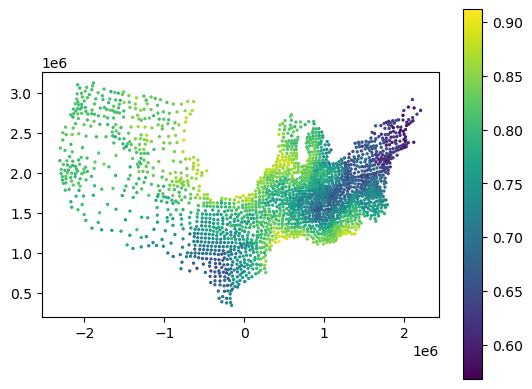

In [11]:
gdf.plot(gwrf.local_oob_score_, legend=True, s=2)

<Axes: >

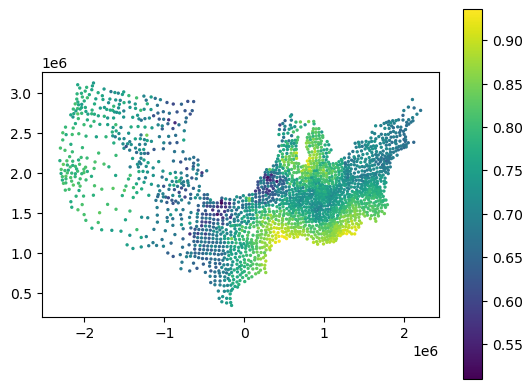

In [12]:
gdf.plot(gwrf.local_oob_precision_, legend=True, s=2)

<Axes: >

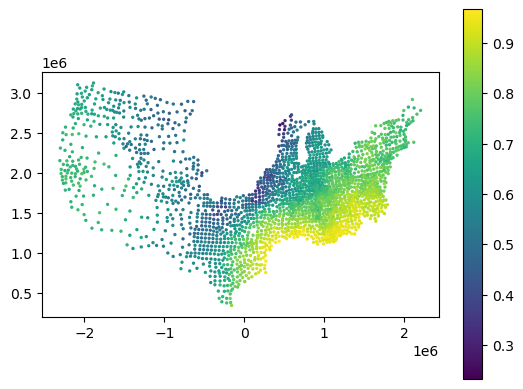

In [13]:
gdf.plot(gwrf.local_oob_recall_, legend=True, s=2)

<Axes: >

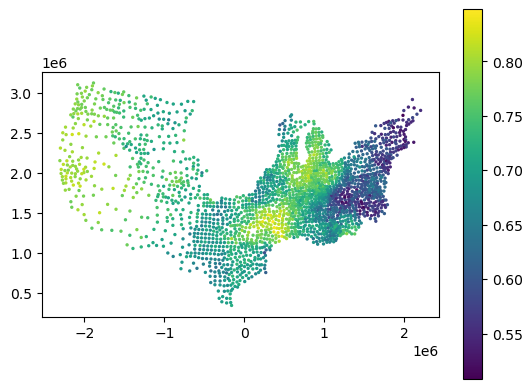

In [14]:
gdf.plot(gwrf.local_oob_balanced_accuracy_, legend=True, s=2)

<Axes: >

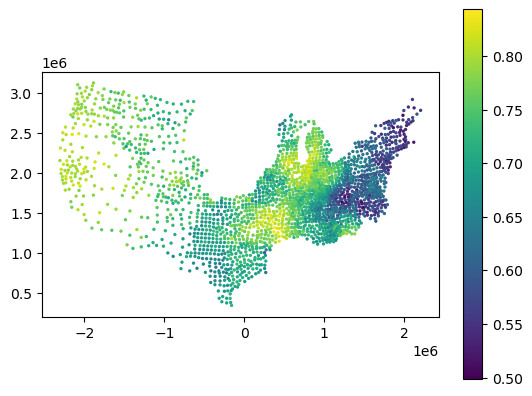

In [15]:
gdf.plot(gwrf.local_oob_f1_macro_, legend=True, s=2)

<Axes: >

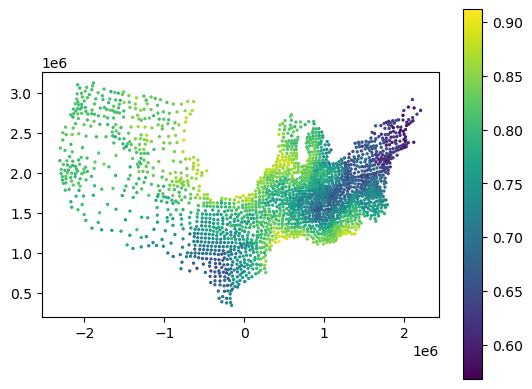

In [16]:
gdf.plot(gwrf.local_oob_f1_micro_, legend=True, s=2)

<Axes: >

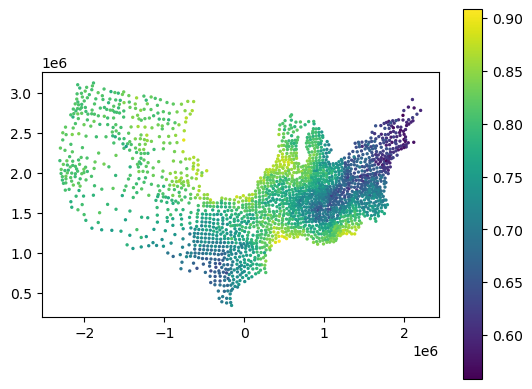

In [17]:
gdf.plot(gwrf.local_oob_f1_weighted_, legend=True, s=2)

<Axes: >

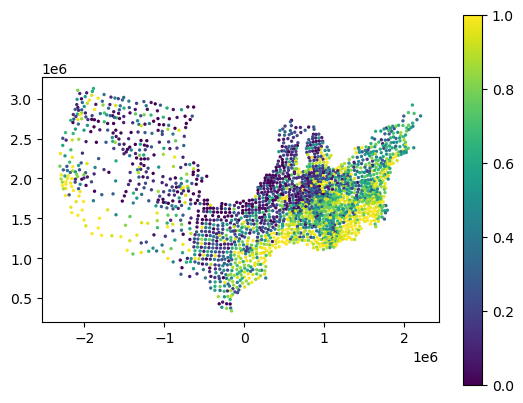

In [18]:
gdf.plot(gwrf.focal_proba_[True], legend=True, s=2)

<Axes: >

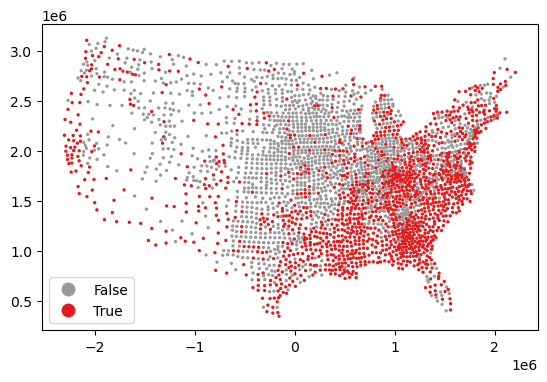

In [19]:
gdf.plot(y, legend=True, s=2, cmap="Set1_r")

Global accuracy for the GW model measured based on prediction of focals.

In [20]:
gwrf.score_

0.7670995670995671

F1 scores for the GW model measured based on prediction of focals. 

In [21]:
gwrf.f1_macro_, gwrf.f1_micro_, gwrf.f1_weighted_

(0.7668975720794766, 0.7670995670995671, 0.7671589773995937)

OOB score (accuracy) of the global model.

In [22]:
gwrf.global_model.oob_score_

0.7847649918962722

Get local feature importances.

In [23]:
gwrf.feature_importances_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.163850,0.143912,0.136582,0.172506,0.176878,0.206272
2,0.143847,0.133286,0.116486,0.170144,0.181536,0.254703
3,0.143455,0.147278,0.135663,0.174209,0.163846,0.235549
4,0.176854,0.127674,0.119081,0.164119,0.204923,0.207349
...,...,...,...,...,...,...
3080,0.131392,0.121187,0.210867,0.080780,0.295454,0.160320
3081,0.152491,0.107219,0.165394,0.192854,0.222658,0.159383
3082,0.163262,0.195136,0.186034,0.223107,0.086872,0.145588
3083,0.151720,0.169970,0.197951,0.250114,0.104788,0.125457


<Axes: >

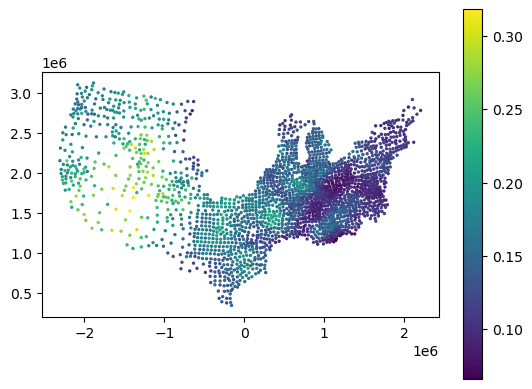

In [24]:
gdf.plot(gwrf.feature_importances_["HC60"], legend=True, s=2)

Compare to global feature importance.

In [25]:
gwrf.global_model.feature_importances_

array([0.1347237 , 0.1506066 , 0.18056572, 0.20387579, 0.12572477,
       0.20450342])

### Gradient boosting

In [26]:
gwgb = GWGradientBoostingClassifier(
    bandwidth=250,
    fixed=False,
    n_jobs=-1,
    keep_models=False,
)
gwgb.fit(
    gdf.iloc[:, 9:15],
    y,
    gdf.geometry,
)

Global score (accuracy) for the GW model measured based on prediction of focals.

In [27]:
gwgb.score_

0.7545454545454545

F1 scores for the GW model measured based on prediction of focals. 

In [28]:
gwgb.f1_macro_, gwgb.f1_micro_, gwgb.f1_weighted_

(0.75437417332864, 0.7545454545454545, 0.7546212675430609)

Get local feature importances.

In [29]:
gwgb.feature_importances_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.177807,0.126379,0.062514,0.157019,0.153172,0.323109
2,0.184493,0.126306,0.062823,0.167385,0.121183,0.337810
3,0.155949,0.137035,0.075270,0.167757,0.068638,0.395349
4,0.170747,0.128077,0.076032,0.156337,0.114440,0.354367
...,...,...,...,...,...,...
3080,0.101786,0.054407,0.146009,0.050640,0.585449,0.061709
3081,0.090220,0.077285,0.132755,0.208580,0.456479,0.034682
3082,0.117778,0.191602,0.192507,0.315018,0.059263,0.123832
3083,0.147443,0.146816,0.155618,0.384426,0.051092,0.114605


<Axes: >

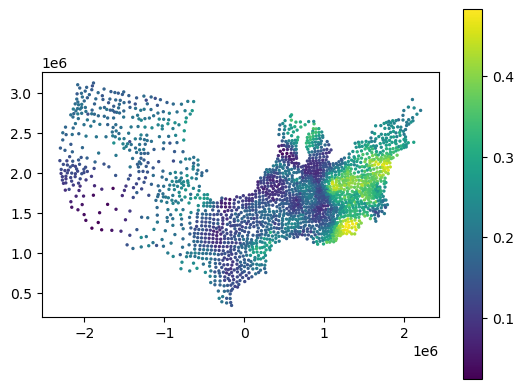

In [30]:
gdf.plot(gwgb.feature_importances_["HR90"], legend=True, s=2)

Compare to global feature importance.

In [31]:
gwgb.global_model.feature_importances_

array([0.05644238, 0.05572028, 0.1228957 , 0.15106316, 0.22054067,
       0.3933378 ])

### Logistic regression

In [32]:
gwlr = GWLogisticRegression(
    bandwidth=900_000,
    fixed=True,
    n_jobs=-1,
    keep_models=True,
    max_iter=500,
)
gwlr.fit(
    pd.DataFrame(
        preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
    ),
    gdf["FH90"] > gdf["FH90"].median(),
    gdf.geometry,
)

In [33]:
gwlr.score_

0.7911936704506364

In [34]:
gwlr.pred_f1_micro_

0.7864280001426905

<Axes: >

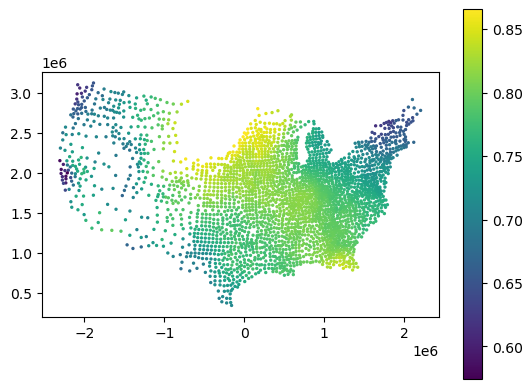

In [35]:
gdf.plot(gwlr.local_pred_f1_micro_, legend=True, s=2)

In [36]:
gwlr.f1_macro_, gwlr.f1_micro_, gwlr.f1_weighted_

(0.7911541287072663, 0.7911936704506364, 0.7912401319990963)

Local coefficients

In [37]:
gwlr.local_coef_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.286802,0.123161,0.099993,0.359248,1.357041,0.864515
2,0.311253,0.157535,0.046688,0.273231,1.380707,0.857892
3,0.299757,0.198515,0.035917,0.216032,1.324819,0.895019
4,0.309365,0.149005,0.073854,0.276963,1.378795,0.840442
...,...,...,...,...,...,...
3080,0.084373,0.360897,0.506413,-0.027660,1.115072,0.724758
3081,0.118441,0.106981,0.573711,0.347592,1.512293,0.827530
3082,-0.115461,0.503123,0.322601,0.657267,1.764582,1.215657
3083,-0.142727,0.468729,0.371395,0.609215,2.124454,1.390968


<Axes: >

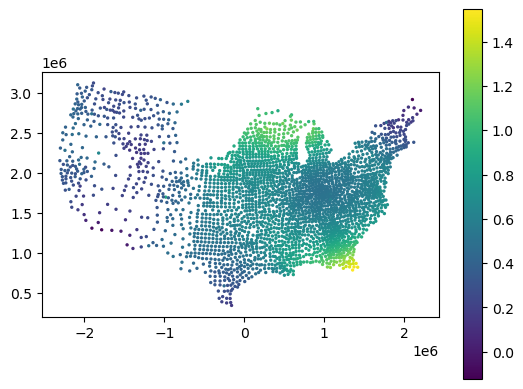

In [38]:
gdf.plot(gwlr.local_coef_["HR90"], legend=True, s=2)

Local intercepts

<Axes: >

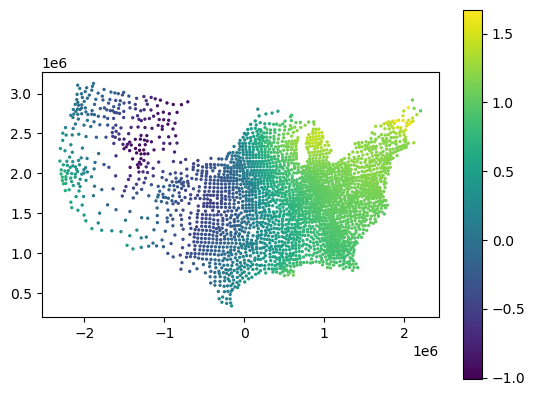

In [39]:
gdf.plot(gwlr.local_intercept_, s=2, legend=True)

## Bandwidth search

Golden section search with a fixed distance bandwidth.

In [46]:
search = BandwidthSearch(
    GWLogisticRegression,
    fixed=True,
    n_jobs=-1,
    search_method="golden_section",
    criterion="aic",
    max_iterations=3,
    min_bandwidth=250_000,
    max_bandwidth=2_000_000,
    verbose=True,
    max_iter=500,
)
search.fit(
    gdf.iloc[:, 9:15],
    y,
    gdf.geometry,
)

Fitting bandwidth: 918447.5
-0.4081785661481215 2918 6
Bandwidth: 918447.5, Score: 12.816
Fitting bandwidth: 1331552.5
-0.4112848331214553 3073 6
Bandwidth: 1331552.5, score: 12.823


Get the optimal one.

In [47]:
search.scores_

918447.5     12.816357
1331552.5    12.822570
Name: oob_score, dtype: float64

Golden section search with an adaptive KNN bandwidth.

In [17]:
search = BandwidthSearch(
    GWLogisticRegression,
    fixed=False,
    n_jobs=-1,
    search_method="interval",
    min_bandwidth=50,
    max_bandwidth=1000,
    interval=100,
    criterion="aicc",
    verbose=True,
    max_iter=500,  # passed to log regr
)
search.fit(
    pd.DataFrame(
        preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
    ),
    y,
    gdf.geometry,
)

Bandwidth: 50.00, score: 3496.602
Bandwidth: 150.00, score: 2590.608
Bandwidth: 250.00, score: 2470.417
Bandwidth: 350.00, score: 2467.736
Bandwidth: 450.00, score: 2507.082
Bandwidth: 550.00, score: 2522.316
Bandwidth: 650.00, score: 2543.729
Bandwidth: 750.00, score: 2612.469
Bandwidth: 850.00, score: 2655.850
Bandwidth: 950.00, score: 2712.442


<Axes: >

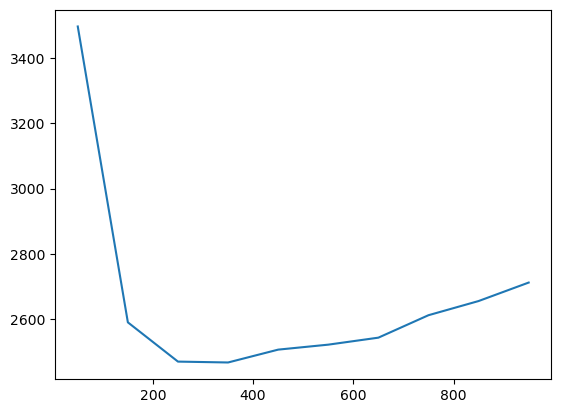

In [18]:
search.scores_.plot()

Get the optimal one.

In [19]:
search.optimal_bandwidth_

np.int64(350)

## Prediction

If you want to use the model for prediction, all the local models need to be retained. That may require significant memory for RF.

In [58]:
gwlr = GWLogisticRegression(
    bandwidth=918447,
    fixed=True,
    n_jobs=-1,
    verbose=True,
    max_iter=500,  # passed to log regr
    measure_performance=False,
    keep_models=True,
)
gwlr.fit(
    pd.DataFrame(
        preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
    ),
    gdf["FH90"] > gdf["FH90"].median(),
    gdf.geometry,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [59]:
all_data = pd.DataFrame(
    preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
)

Predict probabilities

In [60]:
pp = gwlr.predict_proba(all_data.iloc[:10], geometry=gdf.geometry.iloc[:10])
pp

,False,True
0,0.820086,0.179914
1,0.620665,0.379335
2,0.692175,0.307825
3,0.650646,0.349354
4,0.717526,0.282474
5,0.757832,0.242168
6,0.643172,0.356828
7,0.772874,0.227126
8,0.534443,0.465557
9,0.785177,0.214823


Predict label (taking max of probabilities)

In [61]:
gwlr.predict(all_data.iloc[5:10], geometry=gdf.geometry.iloc[5:10])

5    False
6    False
7    False
8    False
9    False
dtype: bool